In [1]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
# This notebook is partly adapted from the link below:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

## Fine tune on Empathetic label dataset

In [4]:
#we define the paths for train, val, test, same split as already obtained in the T5 notebook
train_path = "empathy_dataset/train.txt"
test_path = "empathy_dataset/test.txt"
val_path = "empathy_dataset/val.txt"

In [5]:
#create a dictionary associating each string label to an integer value

labels = ["weak", "strong"]
label2int = dict(zip(labels, list(range(len(labels)))))
print(label2int)

{'weak': 0, 'strong': 1}


## Prepare the dataset

In [6]:
class EmpathyDataset(Dataset):
  def __init__(
    self,
    path,
    tokenizer: BertTokenizer,
    max_token_len: int = 100
  ):
    self.tokenizer = tokenizer
    self.data_column = "text"
    self.class_column = "class"
    self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_token_len = max_token_len
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = label2int[data_row["class"]]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return (encoding["input_ids"].flatten(),encoding["attention_mask"].flatten()), torch.tensor(labels)

## Building our classifier

In [7]:
# We are going to use bert-base-uncased
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#using Mish activation function 
#(from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py)
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [9]:
#define an EmpathyClassificationModel class to do the actual fine-tuning

class EmpathyClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, attention_mask, *args):

        hidden_states = self.base_model(input_ids, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

## Prepare lightning module

In [10]:
#use PyTorch Lightning for training.
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmpathyClassificationModel(BertModel.from_pretrained("bert-base-uncased"), len(labels)) #was "distilroberta-base"
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.max_token_length = 128
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        # self.save_hyperparameters(hparams)
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        # print(self.forward(input_ids=X[0], attention_mask = X[1]))
        loss = self.loss(self.forward(input_ids=X[0], attention_mask = X[1]), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()

        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmpathyDataset(ds_path, self.tokenizer, self.max_token_length),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), f'empathy_model/BERT_empathy_2ft.pt')

## Begin training

In [11]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=10,
    warmup_steps=100,
    epochs=30,
    lr=2E-05,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # monitor validation loss
    min_delta=0.001, #to very small change in the monitored quantity to qualify as an improvement
    patience=20, # used to check number of time with no improvement after which training will be stopped
    verbose=False, 
    mode="min" #sed while training will stopped when the quantity monitor has stopped decreasing
    )

In [13]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,
                     early_stop_callback=early_stop_callback)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Epoch 12:  81%|████████  | 60/74 [00:09<00:02,  6.34it/s, loss=0.011, train_loss=0.00121, v_num=117]


1

In [16]:
# save model
# module.save_model()

In [11]:
# load model test
# hparams = Namespace(
#     train_path=train_path,
#     val_path=val_path,
#     test_path=test_path,
#     batch_size=10,
#     warmup_steps=100,
#     epochs=20,
#     lr=2.5E-05,
#     accumulate_grad_batches=1
# )
# device = torch.device('cuda:0')
# module = TrainingModule(hparams)
# module.model.load_state_dict(torch.load('empathy_model/BERT_empathy_2ft.pt'), strict=False)
# module.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TrainingModule(
  (model): EmpathyClassificationModel(
    (base_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        X,y = batch_
        input_ids = X[0]
        attention_mask = X[1]
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(input_ids.to(device), attention_mask.to(device)), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

|
________________________________________________________________________________
              precision    recall  f1-score   support

        weak     0.7917    0.8261    0.8085        23
      strong     0.7333    0.6875    0.7097        16

    accuracy                         0.7692        39
   macro avg     0.7625    0.7568    0.7591        39
weighted avg     0.7677    0.7692    0.7680        39



## Fine tune on EmpatheticPersonas data

In [13]:
#we define the paths for train, val, test
train_path = "empathy_dataset/my_train.txt"
test_path = "empathy_dataset/my_test.txt"
val_path = "empathy_dataset/my_val.txt"

In [14]:
#use PyTorch Lightning for training.
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmpathyClassificationModel(BertModel.from_pretrained("bert-base-uncased"), len(labels)) #was "distilroberta-base"
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.max_token_length = 128
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        # self.save_hyperparameters(hparams)
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        # print(self.forward(input_ids=X[0], attention_mask = X[1]))
        loss = self.loss(self.forward(input_ids=X[0], attention_mask = X[1]), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()

        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmpathyDataset(ds_path, self.tokenizer, self.max_token_length),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self, version):
        torch.save(self.model.state_dict(), f'empathy_model/BERT_empathy_2ft_2.pt')

In [15]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=10,
    warmup_steps=100,
    epochs=20,
    lr=5E-06,
    accumulate_grad_batches=1
)
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [16]:
device = torch.device('cuda:0')
module = TrainingModule(hparams)
module.model.load_state_dict(torch.load('empathy_model/BERT_empathy_2ft.pt'), strict=False)
module.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TrainingModule(
  (model): EmpathyClassificationModel(
    (base_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias

In [17]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # monitor validation loss
    min_delta=0.001, #to very small change in the monitored quantity to qualify as an improvement
    patience=20, # used to check number of time with no improvement after which training will be stopped
    verbose=False, 
    mode="min" #sed while training will stopped when the quantity monitor has stopped decreasing
    )

In [18]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,
                     early_stop_callback=early_stop_callback)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Epoch 17:  96%|█████████▌| 130/136 [00:17<00:00,  7.54it/s, loss=0.059, train_loss=0.00898, v_num=123]


1

In [17]:
# save model
# module.save_model()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        X,y = batch_
        input_ids = X[0]
        attention_mask = X[1]
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(input_ids.to(device), attention_mask.to(device)), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

|
________________________________________________________________________________
              precision    recall  f1-score   support

        weak     0.7353    0.6944    0.7143        36
      strong     0.7027    0.7429    0.7222        35

    accuracy                         0.7183        71
   macro avg     0.7190    0.7187    0.7183        71
weighted avg     0.7192    0.7183    0.7182        71



<AxesSubplot:>

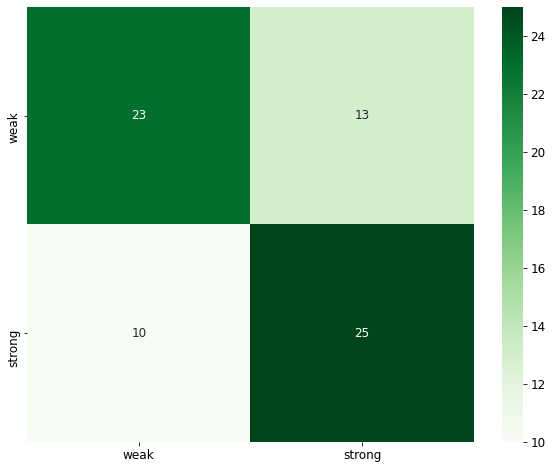

In [19]:
# plot confusion matrix
cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.rcParams.update({'font.size':12})
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')